<h1>Session 13. Fully tuned Decision Tree and Logistic Regression, ROC AUC Score; Turnover data</h1>
<p>This notebook provides an example code of predicting churn of telecom customers by using <b>Decision tree classification</b> with Churn data. 
<br>

The general sequence of steps that we will follow is the following:
<ol>
<li>Describing the data (checking for NAs, 0 variance,summary statistics of our variables, etc)
<li>Separate data into numeric and objec datasets, so to be able to create dummy variables
<li>Checking for correlations between numeric variables, and see that there are many correlated variables
<li>Devide data into training and testing sets 
<li><b> Model 1. Decision tree without scaling the data</b>
<li><b> Model 2. Decision tree with scaled data</b>
<li><b> Model 3. Logistic Regression from statsmodel and interpretation of marginal effects</b>
<li><b> Model 4. Logistic Regression without scaling the data</b>
<li><b> Model 5. Logistic Regression with scaled data</b>
<li> Predicting for new individual using constructed models
<li> Summarising results
</ol>
</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier,export_graphviz 
from sklearn.model_selection import train_test_split
from statsmodels.discrete.discrete_model import Logit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

In [2]:
#read data
data=pd.read_csv("turnover.csv")

In [3]:
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,churn,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
#checking for missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
work_accident            14999 non-null int64
churn                    14999 non-null int64
promotion_last_5years    14999 non-null int64
department               14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [5]:
#deviding into numeric and object data
data_numeric=data.select_dtypes(exclude="object")
data_object=data.select_dtypes(include="object")

In [6]:
#checking for 0 variance
print(data_numeric.var()==0)

satisfaction_level       False
last_evaluation          False
number_project           False
average_montly_hours     False
time_spend_company       False
work_accident            False
churn                    False
promotion_last_5years    False
dtype: bool


In [7]:
for i in data_object.columns:
    print(data_object[i].unique())

['sales' 'accounting' 'hr' 'technical' 'support' 'management' 'IT'
 'product_mng' 'marketing' 'RandD']
['low' 'medium' 'high']


In [8]:
#converting into dummy variables
data_dummies=pd.get_dummies(data_object,prefix=data_object.columns,drop_first=True)

In [9]:
#joining back numeric and dummy data
data_final=pd.DataFrame(data_numeric.join(data_dummies))
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 19 columns):
satisfaction_level        14999 non-null float64
last_evaluation           14999 non-null float64
number_project            14999 non-null int64
average_montly_hours      14999 non-null int64
time_spend_company        14999 non-null int64
work_accident             14999 non-null int64
churn                     14999 non-null int64
promotion_last_5years     14999 non-null int64
department_RandD          14999 non-null uint8
department_accounting     14999 non-null uint8
department_hr             14999 non-null uint8
department_management     14999 non-null uint8
department_marketing      14999 non-null uint8
department_product_mng    14999 non-null uint8
department_sales          14999 non-null uint8
department_support        14999 non-null uint8
department_technical      14999 non-null uint8
salary_low                14999 non-null uint8
salary_medium             14999 non-null 

In [10]:
#let's see percenatage of employees who didn't churn,
#and percenatage of employees who churned
print(data_final.churn.value_counts()/len(data)*100)

0    76.191746
1    23.808254
Name: churn, dtype: float64


In [11]:
X=data_final.drop("churn",axis=1)
Y=data_final.churn
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

# Model 1. Decision tree without scaling data

In [12]:
#cross validation for DT
tree1=DecisionTreeClassifier(class_weight="balanced",random_state=42)
grid_search=GridSearchCV(tree1,param_grid={"max_depth":range(5,15),"min_samples_leaf":range(10,100)},scoring="roc_auc",cv=5,n_jobs=-1)
grid_search.fit(X,Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(5, 15), 'min_samples_leaf': range(10, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [13]:
#print best parameters and best score
print("Best parameters:",grid_search.best_params_)
print("Best score:",grid_search.best_score_.round(2)*100)

Best parameters: {'max_depth': 14, 'min_samples_leaf': 13}
Best score: 99.0


In [14]:
#Run DT with best parameters
tree1=DecisionTreeClassifier(max_depth=14,min_samples_leaf=13,class_weight="balanced",random_state=42)
tree1.fit(x_train,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=14, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=13, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [15]:
#printing accuracy score for train and test data
print("Train:",tree1.score(x_train,y_train).round(2)*100)
print("Test:",tree1.score(x_test,y_test).round(2)*100)

Train: 97.0
Test: 96.0


In [16]:
#calculating recall
ypred1=tree1.predict(x_test)
recall_DT1=recall_score(y_test,ypred1)
print("Recall for DT 1:",recall_DT1.round(2)*100)

Recall for DT 1: 94.0


In [17]:
#printing classification report
print(classification_report(y_test,ypred1))

             precision    recall  f1-score   support

          0       0.98      0.96      0.97      2853
          1       0.89      0.94      0.91       897

avg / total       0.96      0.96      0.96      3750



In [18]:
#calculating ROC-AUC score
roc_auc1=roc_auc_score(y_test,ypred1).round(2)*100
print(roc_auc1)

95.0


In [19]:
#for constructing ROC curve, getting TPR,FPR for different Treshold values 
roc_curve_values=roc_curve(y_test,ypred1)
FPR,TPR,Tresholds=roc_curve_values

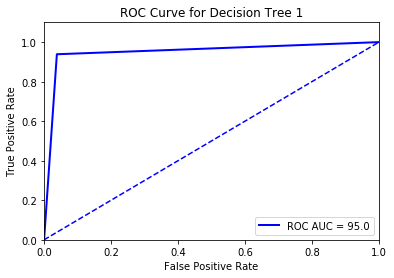

In [20]:
#Plotting ROC curve
plt.figure()
plt.plot(FPR, TPR, color='blue', lw=2, label='ROC AUC = %0.1f'%roc_auc1)
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.title('ROC Curve for Decision Tree 1')
plt.legend(loc="lower right")
plt.show()

<h1>Model 2. Decision tree with scaled data</h1>

In [21]:
#let's remove from numeric data "churn" as we don't need to scale dependent variable
data_numeric_new=data_numeric.drop("churn",axis=1)

In [22]:
#scaling data using standard method (MinMAx method can be also used, see: sklearn.preprocessing.MinMaxScaler)
#fitting only to the training data,i.e. computing the mean and std  dev to be used for later scaling
scaler = StandardScaler()
scaler.fit(data_numeric_new)
#let's perform the transformations of the data
data_numeric_scaled= pd.DataFrame(scaler.transform(data_numeric_new),columns=data_numeric_new.columns)

In [23]:
#let's join all X variables and devide data into train and test sets
X_scaled=data_numeric_scaled.join(data_dummies)
x_train_scaled,x_test_scaled,y_train,y_test=train_test_split(X_scaled,Y,test_size=0.25,random_state=42)

In [24]:
#cross validation for DT
tree2=DecisionTreeClassifier(class_weight="balanced",random_state=42)
grid_search2=GridSearchCV(tree2,param_grid={"max_depth":range(5,15),"min_samples_leaf":range(10,100)},cv=5,scoring="roc_auc",n_jobs=-1)
grid_search2.fit(X_scaled,Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(5, 15), 'min_samples_leaf': range(10, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [25]:
#print best parameters and best score
print("Best parameters 2:",grid_search2.best_params_)
print("Best score 2:",grid_search2.best_score_.round(2)*100)

Best parameters 2: {'max_depth': 14, 'min_samples_leaf': 13}
Best score 2: 99.0


In [26]:
#Run DT with best parameters
tree2=DecisionTreeClassifier(max_depth=14,min_samples_leaf=13,class_weight="balanced",random_state=42)
tree2.fit(x_train_scaled,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=14, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=13, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [27]:
#printing accuracy score for train and test data
print("Train",tree2.score(x_train_scaled,y_train).round(2)*100)
print("Test",tree2.score(x_test_scaled,y_test).round(2)*100)

Train 97.0
Test 96.0


In [28]:
#calculating recall
ypred2=tree2.predict(x_test_scaled)
recall_DT2=recall_score(y_test,ypred2)
print("Recall for DT 2:",recall_DT2.round(2)*100)

Recall for DT 2: 94.0


In [29]:
#calculating ROC-AUC score
roc_auc2=roc_auc_score(y_test,ypred2).round(2)*100
print(roc_auc2)

95.0


<h1>Model 3. Logistic regression from statsmodel</h1>

In [30]:
formula='churn~'+'+'.join(X.columns.tolist())
formula

'churn~satisfaction_level+last_evaluation+number_project+average_montly_hours+time_spend_company+work_accident+promotion_last_5years+department_RandD+department_accounting+department_hr+department_management+department_marketing+department_product_mng+department_sales+department_support+department_technical+salary_low+salary_medium'

In [31]:
logit1=Logit.from_formula(formula=formula,data=data_final).fit()

Optimization terminated successfully.
         Current function value: 0.428358
         Iterations 7


In [32]:
logit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                14999
Model:                          Logit   Df Residuals:                    14980
Method:                           MLE   Df Model:                           18
Date:                Mon, 19 Nov 2018   Pseudo R-squ.:                  0.2195
Time:                        23:19:53   Log-Likelihood:                -6424.9
converged:                       True   LL-Null:                       -8232.3
                                        LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1.6570      0.189     -8.784      0.000      -2.027      -1.287
satisfaction_level        -4.1357      0.098    -42.177      0.000      -4.328      -3.944
last_evaluation            0.7309      0.149      4.899      0.000       0.439       1.023
number_project            -0.3151      0.021    -14.775      0.000      -0.357      -0.273
average_montly_hours       0.0045      0.001      8.643      0.000       0.003       0.005
time_spend_company         0.2678      0.016     17.192      0.000       0.237       0.298
work_accident             -1.5298      0.090    -17.083      0.000      -1.705      -1.354
promotion_last_5years     -1.4301      0.258     -5.552      0.000      -1.935      -0.925
department_RandD          -0.4016      0.136     -2.962      0.003      -0.667      -0.136
department_accounting      0.1807      0.122      1.480      0.139      -0.059       0.420
department_hr              0.4131      0.121      3.415      0.001       0.176       0.650
department_management     -0.2677      0.152     -1.765      0.078      -0.565       0.030
department_marketing       0.1686      0.122      1.386      0.166      -0.070       0.407
department_product_mng     0.0275      0.120      0.230      0.818      -0.207       0.262
department_sales           0.1419      0.089      1.601      0.109      -0.032       0.316
department_support         0.2307      0.097      2.391      0.017       0.042       0.420
department_technical       0.2509      0.093      2.685      0.007       0.068       0.434
salary_low                 1.9441      0.129     15.111      0.000       1.692       2.196
salary_medium              1.4132      0.129     10.924      0.000       1.160       1.667
==========================================================================================
"""

In [33]:
#let's get marginal effects to interpret the results of logistic regression
logit1.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                  churn
Method:                          dydx
At:                           overall
==========================================================================================
                            dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
satisfaction_level        -0.5700      0.010    -54.709      0.000      -0.590      -0.550
last_evaluation            0.1007      0.021      4.911      0.000       0.061       0.141
number_project            -0.0434      0.003    -15.071      0.000      -0.049      -0.038
average_montly_hours       0.0006   7.05e-05      8.716      0.000       0.000       0.001
time_spend_company         0.0369      0.002     17.744      0.000       0.033       0.041
work_accident             -0.2108      0.012    -17.541      0.000      -0.234      -0.187
promotion_last_5years     -0.1971      0.035     -5.566      0.000      -0.267      -0.128
department_RandD          -0.0554      0.019     -2.965      0.003      -0.092      -0.019
department_accounting      0.0249      0.017      1.480      0.139      -0.008       0.058
department_hr              0.0569      0.017      3.419      0.001       0.024       0.090
department_management     -0.0369      0.021     -1.765      0.078      -0.078       0.004
department_marketing       0.0232      0.017      1.386      0.166      -0.010       0.056
department_product_mng     0.0038      0.016      0.230      0.818      -0.029       0.036
department_sales           0.0196      0.012      1.601      0.109      -0.004       0.044
department_support         0.0318      0.013      2.392      0.017       0.006       0.058
department_technical       0.0346      0.013      2.687      0.007       0.009       0.060
salary_low                 0.2679      0.017     15.426      0.000       0.234       0.302
salary_medium              0.1948      0.018     11.030      0.000       0.160       0.229
==========================================================================================
"""

<b>Interpreting for cont variable</b>. As satisfaction_level is statistically significant at 5% sig level (P>|z|<=0.05), so there is sig relationship between churn and satisfaction_level. Incremental increase in satisfaction_level decreases the probability of churn on average by 0.57.

# Model 4. Logistic regression using cross validation

In [34]:
#Logit from sklearn for prediction
logit2=LogisticRegression(random_state=42,class_weight="balanced")
grid_search3=GridSearchCV(logit2,param_grid={"C":np.linspace(0.001,10,10)},cv=5,scoring="roc_auc",n_jobs=-1)
grid_search3.fit(X,Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([1.000e-03, 1.112e+00, 2.223e+00, 3.334e+00, 4.445e+00, 5.556e+00,
       6.667e+00, 7.778e+00, 8.889e+00, 1.000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [35]:
grid_search3.best_params_

{'C': 1.1119999999999999}

In [36]:
best=list(grid_search3.best_params_.values())[0]

In [37]:
logit2=LogisticRegression(C=best,random_state=42,class_weight="balanced")
logit2.fit(x_train,y_train)

LogisticRegression(C=1.1119999999999999, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [38]:
print("Train:",logit2.score(x_train,y_train).round(2)*100)
print("Test:",logit2.score(x_test,y_test).round(2)*100)
ypred3=logit2.predict(x_test)
print("recall:",recall_score(y_test,ypred3).round(2)*100)
#calculating ROC-AUC score
roc_auc3=roc_auc_score(y_test,ypred3).round(2)*100
print("roc_auc3:",roc_auc3)

Train: 76.0
Test: 76.0
recall: 81.0
roc_auc3: 78.0


In [39]:
#for constructing ROC curve, getting TPR,FPR for different Treshold values 
roc_curve_values2=roc_curve(y_test,ypred3)
FPR2,TPR2,Tresholds2=roc_curve_values2

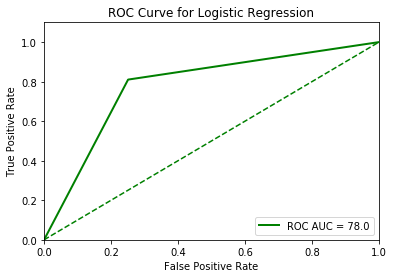

In [40]:
#Plotting ROC curve
plt.figure()
plt.plot(FPR2, TPR2, color='green', lw=2, label='ROC AUC = %0.1f'%roc_auc3)
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

# Model 5. Logistic regression with Scaled data

In [41]:
#Logit from sklearn for prediction
logit3=LogisticRegression(random_state=42,class_weight="balanced")
grid_search4=GridSearchCV(logit3,param_grid={"C":np.linspace(0.001,10,10)},scoring="roc_auc",cv=5,n_jobs=-1)
grid_search4.fit(X_scaled,Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([1.000e-03, 1.112e+00, 2.223e+00, 3.334e+00, 4.445e+00, 5.556e+00,
       6.667e+00, 7.778e+00, 8.889e+00, 1.000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [42]:
print(grid_search4.best_params_)
best2=list(grid_search4.best_params_.values())[0]

{'C': 1.1119999999999999}


In [43]:
#running Logit with best lamda
logit3=LogisticRegression(C=best2,random_state=42,class_weight="balanced")
logit3.fit(x_train_scaled,y_train)

LogisticRegression(C=1.1119999999999999, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [44]:
ypred4=logit3.predict(x_test_scaled)
print("Train:",logit3.score(x_train_scaled,y_train).round(2)*100)
print("Test:",logit3.score(x_test_scaled,y_test).round(2)*100)
print("Recall:",recall_score(y_test,ypred3).round(2)*100)
print("ROC AUC:",roc_auc_score(y_test,ypred4).round(2)*100)

Train: 76.0
Test: 76.0
Recall: 81.0
ROC AUC: 78.0


# Predicting for new individual using constructed models

In [45]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11249 entries, 14480 to 7270
Data columns (total 18 columns):
satisfaction_level        11249 non-null float64
last_evaluation           11249 non-null float64
number_project            11249 non-null int64
average_montly_hours      11249 non-null int64
time_spend_company        11249 non-null int64
work_accident             11249 non-null int64
promotion_last_5years     11249 non-null int64
department_RandD          11249 non-null uint8
department_accounting     11249 non-null uint8
department_hr             11249 non-null uint8
department_management     11249 non-null uint8
department_marketing      11249 non-null uint8
department_product_mng    11249 non-null uint8
department_sales          11249 non-null uint8
department_support        11249 non-null uint8
department_technical      11249 non-null uint8
salary_low                11249 non-null uint8
salary_medium             11249 non-null uint8
dtypes: float64(2), int64(5), uint8(11

In [46]:
#Let's give each variable any value
X_new=[[5,0.87,7,300,2,1,0,0,0,1,0,0,0,0,0,0,0,1]]

In [47]:
##Predicting for unseen X_new using logit and DT
logit_pred=logit2.predict(X_new)
DT_pred=tree1.predict(X_new)
print("logit_pred:",logit_pred)
print("tree_pred",DT_pred)

logit_pred: [0]
tree_pred [1]


<b>So, logit model predicts that employee won't churn and decision tree predicts that s/he will churn.</b>

<h1>Summarising results</h1>

In [48]:
#Printing recall for not scaled data models
print("Recall scores for not scaled models")
for i in [tree1,logit2]:
    print("Recall:",(recall_score(y_test,i.predict(x_test))).round(2)*100)
print("\n","---------------------------------------")

#ROC AUC
print("ROC AUC scores for not scaled models")
for i in [tree1,logit2]:
    print("ROC AUC:",(roc_auc_score(y_test,i.predict(x_test))).round(2)*100)
    
print("\n","---------------------------------------")
print("Train scores for not scaled models")
for i in [tree1,logit2]:
    print("Train scores:",(i.score(x_train,y_train)).round(2)*100)

print("\n","---------------------------------------")
print("Test scores for not scaled models")
for i in [tree1,logit2]:
    print("Test scores:",(i.score(x_test,y_test)).round(2)*100)

print("\n","---------------------------------------")
print("Recall scores for scaled models")
for i in [tree2,logit3]:
    print("Recall:",(recall_score(y_test,i.predict(x_test_scaled))).round(2)*100)

print("\n","---------------------------------------")
print("ROC AUC scores for scaled models")
for i in [tree2,logit3]:
    print("ROC AUC:",(roc_auc_score(y_test,i.predict(x_test_scaled))).round(2)*100)

print("\n","---------------------------------------")
print("Train scores for scaled models")
for i in [tree2,logit3]:
    print("Train scores:",(i.score(x_train_scaled,y_train)).round(2)*100)

print("\n","---------------------------------------")
print("Test scores for scaled models")
for i in [tree2,logit3]:
    print("Test scores:",(i.score(x_test_scaled,y_test)).round(2)*100)

Recall scores for not scaled models
Recall: 94.0
Recall: 81.0

 ---------------------------------------
ROC AUC scores for not scaled models
ROC AUC: 95.0
ROC AUC: 78.0

 ---------------------------------------
Train scores for not scaled models
Train scores: 97.0
Train scores: 76.0

 ---------------------------------------
Test scores for not scaled models
Test scores: 96.0
Test scores: 76.0

 ---------------------------------------
Recall scores for scaled models
Recall: 94.0
Recall: 81.0

 ---------------------------------------
ROC AUC scores for scaled models
ROC AUC: 95.0
ROC AUC: 78.0

 ---------------------------------------
Train scores for scaled models
Train scores: 97.0
Train scores: 76.0

 ---------------------------------------
Test scores for scaled models
Test scores: 96.0
Test scores: 76.0


<b>As can be seen from the summary, there is no difference in results for Logistic regression and Decision Tree with scaled and not scaled data. </b>